            ----- MADRS prediction 24h segments -----

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import mean_squared_error

import os
import sys
import random

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential, load_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers

import math

In [3]:
# hyperparameters

step = 60 
batch_size = 16
optimizer = optimizers.Adam(lr = 0.00001) # learning rate is very low, otherwise the gradients exploded
verbose = 1
data_dir = "Downloads/depression_data"
segment_length = 1440
learning_rate = 0.0001

Function for creating the segments and corresponding labels for MADRS prediction
 - it will read scores.csv (with all the demographics etc), and generates:
     -> one list of time sliced sequences
     -> one list of the corresponding participants' labels (madrs scores)

In [4]:
def segments_and_labels(dataset_dir, segment_length, step):
    scores = pd.read_csv(os.path.join(dataset_dir, 'scores.csv'))
    scores['madrs2'].fillna(0, inplace=True)

    segments = []
    labels = []

    for person in scores['number']:
        p = scores[scores['number'] == person]
        filepath = os.path.join(dataset_dir, person.split('_')[0], f'{person}.csv')
        df_activity = pd.read_csv(filepath)

        for i in range(0, len(df_activity) - segment_length, step):
            segment = df_activity['activity'].values[i : i + segment_length]
            
            segments.append([segment])
            labels.append(p['madrs2'].values[0])

    segments = np.asarray(segments)
    segments = segments.reshape(-1, segment_length, 1)

    input_shape = segments.shape[1]
    segments = segments.reshape(segments.shape[0], input_shape).astype('float32')
    labels = np.asarray(labels).astype('float32')

    return segments, labels, input_shape

print(segments_and_labels(data_dir,segment_length,step))

(array([[  0., 143.,   0., ..., 306.,  91., 296.],
       [306., 286.,  12., ...,  58.,  17., 386.],
       [  0.,   0.,  21., ...,  73., 172., 306.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32), array([19., 19., 19., ...,  0.,  0.,  0.], dtype=float32), 1440)


Splitting dataset, later I will add a validation set as well

In [5]:
segments, labels, input_shape = segments_and_labels(data_dir,segment_length,step)

X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=777)
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(19920, 1440)

(4981, 1440)

(19920,)

(4981,)


In [ ]:
Normalization

In [7]:
sc = MinMaxScaler(feature_range = (0,1))
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
y_train_scaled = sc.fit_transform(y_train.reshape(-1,1))
y_test_scaled = sc.fit_transform(y_test.reshape(-1,1))

print(X_train_scaled.shape)
print()
print(X_test_scaled.shape)
print()
print(y_train_scaled.shape)
print()
print(y_test_scaled.shape)

(19920, 1440)

(4981, 1440)

(19920, 1)

(4981, 1)


Reshaping, otherwise it won't fit in the LSTM model

In [8]:
X_train_scaled_res = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

y_train_scaled_res = np.reshape(y_train_scaled, (y_train_scaled.shape[0], y_train_scaled.shape[1], 1))

X_test_scaled_res = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

y_test_scaled_res = np.reshape(y_test_scaled, (y_test_scaled.shape[0], y_test_scaled.shape[1], 1))

print(X_train_scaled_res.shape)
print()
print(y_train_scaled_res.shape)
print()
print(X_test_scaled_res.shape)
print()
print(y_test_scaled_res.shape)

(19920, 1440, 1)

(19920, 1, 1)

(4981, 1440, 1)

(4981, 1, 1)


Building LSTM model

In [9]:
def build_model():
    model = Sequential()
    model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train_scaled.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30, return_sequences = True, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 30))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='lecun_normal', activation='linear'))
    model.compile(optimizer = optimizer, 
                  loss = 'mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    return model

Cross-validation + validation samples

In [10]:
train_data = X_train_scaled_res
train_targets = y_train_scaled_res
k = 3
num_val_samples = len(train_data) // k
num_epochs = 4
all_scores = [] # Should add the score of each run at the end of the loop
all_mae_histories = []
val_all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model 
    model = build_model()
    # Train the model 
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_history = history.history['root_mean_squared_error']
    all_mae_histories.append(mae_history)
    val_mae_history = history.history['val_root_mean_squared_error']
    val_all_mae_histories.append(val_mae_history)
    
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/4
830/830 [==============================] - 834s 1s/step - loss: 0.1677 - root_mean_squared_error: 0.4094 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 2/4
830/830 [==============================] - 792s 954ms/step - loss: 0.1233 - root_mean_squared_error: 0.3511 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 3/4
830/830 [==============================] - 813s 980ms/step - loss: 0.1221 - root_mean_squared_error: 0.3495 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3455
Epoch 4/4
830/830 [==============================] - 796s 959ms/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.1193 - val_root_mean_squared_error: 0.3454
processing fold # 1
Epoch 1/4
830/830 [==============================] - 794s 952ms/step - loss: 0.1402 - root_mean_squared_error: 0.3742 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 2/4
830/830 [==============================] - 830s 1s/step - loss: 0.1241 - root_

In [23]:
print(np.mean([0.1193,0.1214,0.1225]))

0.12106666666666666


Training and validation results of 24h segment LSTM MODEL

In [11]:
print("RMSE of fold 1, 2 and 3:\n")
print(all_scores)
print()
print("Mean RMSE of all folds:\n")
print(np.mean(all_scores))

RMSE of fold 1, 2 and 3:

[0.34541836380958557, 0.34847384691238403, 0.35005804896354675]

Mean RMSE of all folds:

0.3479834198951721


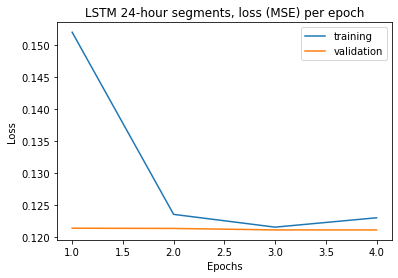

In [25]:
average_loss = [0.152,0.1235,0.1215,0.12296666666666667]
average_val_loss = [0.12133333333333333,0.1213,0.12106666666666667,0.12106666666666666]

plt.plot(range(1, len(average_loss) + 1), average_loss)
plt.plot(range(1, len(average_val_loss) + 1), average_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.title('LSTM 24-hour segments, loss (MSE) per epoch')
plt.show()

Average per-epoch RMSE for all folds

In [26]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

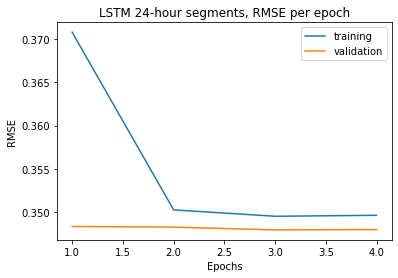

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+ 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history)+ 1), val_average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.title('LSTM 24-hour segments, RMSE per epoch')
plt.show()

In [35]:
print(average_mae_history)
print(val_average_mae_history)

[0.3707701563835144, 0.3502568205197652, 0.3495185375213623, 0.34962870677312213]
[0.34833715359369916, 0.34826406836509705, 0.34794117013613385, 0.34798340996106464]


Training final model on all of the training data and evaluate on test set

In [29]:
test_data = X_test_scaled_res 
test_targets = y_test_scaled_res

In [30]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history_test = model.fit(train_data, train_targets,
                        epochs=12, batch_size=16, verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/12
1245/1245 [==============================] - 1106s 886ms/step - loss: 0.1425 - root_mean_squared_error: 0.3771
Epoch 2/12
1245/1245 [==============================] - 1075s 863ms/step - loss: 0.1234 - root_mean_squared_error: 0.3513
Epoch 3/12
1245/1245 [==============================] - 1066s 856ms/step - loss: 0.1236 - root_mean_squared_error: 0.3515
Epoch 4/12
1245/1245 [==============================] - 1132s 910ms/step - loss: 0.1215 - root_mean_squared_error: 0.3486
Epoch 5/12
1245/1245 [==============================] - 1112s 894ms/step - loss: 0.1218 - root_mean_squared_error: 0.3489
Epoch 6/12
1245/1245 [==============================] - 1221s 980ms/step - loss: 0.1219 - root_mean_squared_error: 0.3492
Epoch 7/12
1245/1245 [==============================] - 1199s 963ms/step - loss: 0.1214 - root_mean_squared_error: 0.3484
Epoch 8/12
1245/1245 [==============================] - 1108s 890ms/step - loss: 0.1217 - root_mean_squared_error: 0.3489
Epoch 9/12
1245/1245 [==

In [31]:
print("Average Mean Squared Error:\n")
print(test_mse_score)
print()
print("Average Root Mean Squared Error:\n")
print(test_mae_score)

Average Mean Squared Error:

0.12387221306562424

Average Root Mean Squared Error:

0.351954847574234


In [32]:
model_predict = model.predict(X_test_scaled_res, verbose = 1)
model_predict = sc.inverse_transform(model_predict)
print(model_predict)
y_test_inversed = (sc.inverse_transform(y_test_scaled))

156/156 [==============================] - 46s 265ms/step
[[7.019638 ]
 [6.96962  ]
 [6.9209137]
 ...
 [6.973767 ]
 [5.782117 ]
 [6.677314 ]]


In [33]:
y_actual = y_test_inversed
y_predicted = model_predict
 
MSE = mean_squared_error(y_actual, y_predicted)

#print(mean_absolute_error(y_actual, y_predicted))
print("Mean Squared Error:\n")
print(MSE)
print()
RMSE = math.sqrt(MSE)
print("Root Mean Squared Error:\n")
print(RMSE)

Mean Squared Error:

97.11584

Root Mean Squared Error:

9.854736784773502
